### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cufflinks as cf

# Int cufflinks
#making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### 01. Load the Dataset

In [3]:
def load_dataset(path:str) -> pd:
    return pd.read_csv(path)

In [4]:
# Loading data using pandas
path = './diabetes.csv'
dataset = load_dataset(path)
columns = list(dataset.columns)

### 02. Explorethe Dataset

In [5]:
# Explore the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Shows if there are any entries that are NA or NAN
dataset.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [7]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return


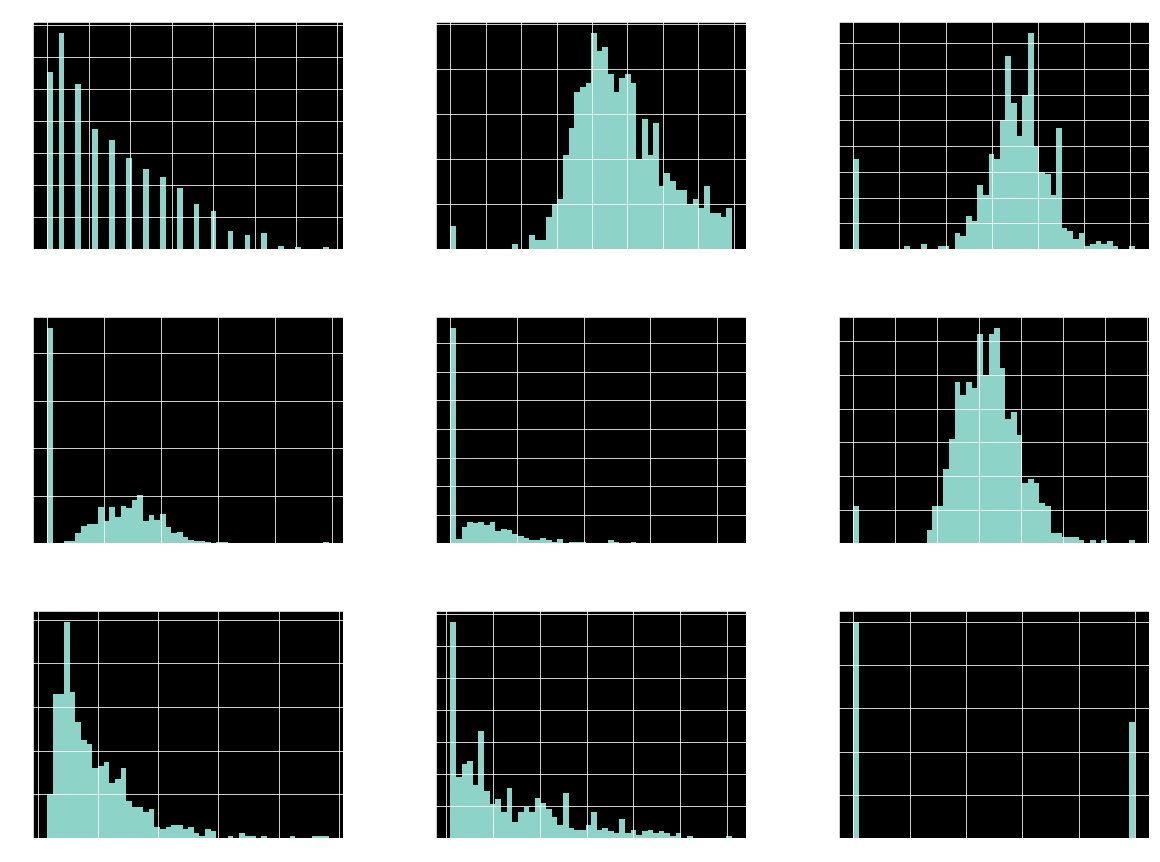

In [8]:
plot_data(dataset)

### 03. Correlation Matrix

<AxesSubplot:>

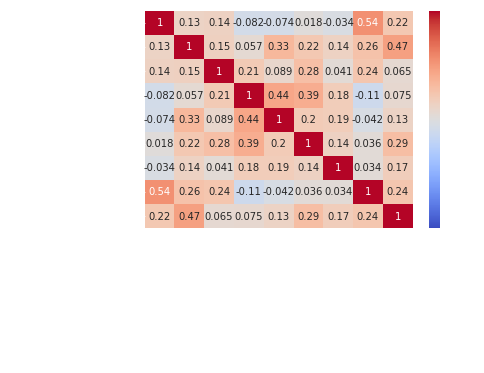

In [9]:
# Correlation data
corr = dataset.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

No meaningful correlation found. All features are informative.

### Functions for Checking Parameters

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

# Check AOC ARC curve
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred, multi_class='ovr')
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'y')

    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    return auc

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred, average='weighted')

    # Check recall
    recall = recall_score(labels_test , pred, average='weighted')

    # Check F1 score
    f1 = f1_score( labels_test , pred, average='weighted')

    print('Accuracy: {}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1))

    #auc = 'NA'
    auc = aoc_arc_curve(pred, labels_test)

    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':f1, 'auc': auc}


### 04 Data Pre-processing

In [12]:
from sklearn.model_selection import train_test_split

# Create features and labels
features = dataset.drop(['Outcome'], axis=1)
labels = dataset['Outcome']

# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)


### 04.1 Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

### 04.2 Imputation

In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(features_train_scaled)
features_train_imputated = imputer.transform(features_train_scaled)

imputer = imputer.fit(features_test_scaled)
features_test_imputated = imputer.transform(features_test_scaled)


### 04.3 Imablanced Data

#### Up-sampling  _(with `imblearn`)_

In [15]:
from imblearn.over_sampling import SMOTE

# Re-sizing the data
features_train_balanced, labels_train_balanced = SMOTE().fit_resample(features_train_imputated, labels_train)
features_test_balanced, labels_test_balanced = SMOTE().fit_resample(features_test_imputated, labels_test)


#### Down-sampling  _(with `imblearn`)_

In [16]:
from imblearn.under_sampling import RandomUnderSampler

# Re-sizing the data
rus = RandomUnderSampler(random_state=42
)
features_train_balanced2, labels_train_balanced2 = rus.fit_resample(features_train_imputated, labels_train)
features_test_balanced2, labels_test_balanced2 = rus.fit_resample(features_test_imputated, labels_test)

## Run Algorithm

In [17]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [18]:
def run_classifier(classifier, features_train, labels_train, features_test, labels_test) -> dict:
    # Cross Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    n_scores = cross_val_score(classifier, features_train, labels_train, scoring='accuracy', cv=cv,
                               n_jobs=-1, error_score='raise')

    # Fit data for training into classifier
    classifier.fit(features_train , labels_train)

    # Predicting with classifier
    acc1 = accuracy_score(y_true=labels_train, y_pred=classifier.predict(features_train))
    acc2 = accuracy_score(y_true=labels_test, y_pred=classifier.predict(features_test))
    return {'accuracy (train data)': acc1, 'accuracy (test data)' : acc2, 'accuracy (mean)' :mean(n_scores),
            'accuracy (std)':std(n_scores) }

In [19]:
def compare_parameters(classif):
    """Parameter Comparison"""
    raw_param = run_classifier(classif, features_train, labels_train, features_test, labels_test)
    scaled_param = run_classifier(classif, features_train_scaled, labels_train, features_test_scaled, labels_test)
    imputed_param = run_classifier(classif, features_train_imputated, labels_train, features_test_imputated, labels_test)
    upsamp_param = run_classifier(classif, features_train_balanced, labels_train_balanced, features_test_balanced, labels_test_balanced)
    downsamp_param = run_classifier(classif, features_train_balanced2, labels_train_balanced2, features_test_balanced2, labels_test_balanced2)

    # Plot out different parameters
    compare = [raw_param, scaled_param, imputed_param, downsamp_param, upsamp_param]
    headers_comparison = ['Raw', 'Scaled', 'Imputed', 'Down-sampling (Imblearn)', 'Up-sampling (Imblearn)']

    # Create dataframe for parameter comparison
    compare_df = pd.DataFrame(compare)
    compare_df["results"]=headers_comparison
    compare_df = compare_df.set_index('results', drop=True).rename_axis(None)

    # Plot
    # compare_df.iplot(kind='bar', width=0.9)
    compare_df.iplot(kind='line')

In [20]:
# Run classifier
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier()
compare_parameters(classifier)


In [21]:
def run_evaluation(models):
    """Run evaluation based of models of classifiers given"""
    # Evaluate each model and store results
    results = { name: run_classifier(mod, features_train, labels_train, features_test, labels_test) \
                for name, mod in models.items() }
    # Turn results into dataframe
    results_df = pd.DataFrame(results)
    # Drop rows not wanted for plot
    results_df2 = results_df.drop(['accuracy (train data)', 'accuracy (test data)'])

    # Visualize
    for name, val in results_df2.items():
        print('>%s %.3f (%.3f)' % (name, val['accuracy (mean)'], val['accuracy (std)']))
    plt.boxplot(results_df2, labels=results_df2.columns, showmeans=True)
    plt.show()



#### Explore Number of Trees

In [22]:
def get_models():
    """Get a list of models with different n_estimators"""
    return { str(n): AdaBoostClassifier(n_estimators=n) for n in [10, 50, 100, 500, 1000, 5000] }


>10 0.773 (0.044)
>50 0.759 (0.046)
>100 0.760 (0.052)
>500 0.740 (0.070)
>1000 0.730 (0.068)
>5000 0.721 (0.071)


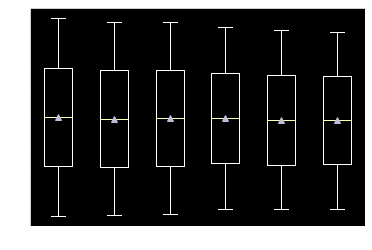

In [23]:
models = get_models()
run_evaluation(models)


#### Explore weak learners

In [24]:
from sklearn.tree import DecisionTreeClassifier

# get a list of models to evaluate
def get_models():
    """Returns a list of models with different DT depth"""
    return { str(i) : AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=i)) for i in range(1,11) }


>1 0.759 (0.046)
>2 0.733 (0.056)
>3 0.731 (0.051)
>4 0.729 (0.068)
>5 0.731 (0.068)
>6 0.747 (0.062)
>7 0.744 (0.054)
>8 0.756 (0.058)
>9 0.751 (0.061)
>10 0.765 (0.054)


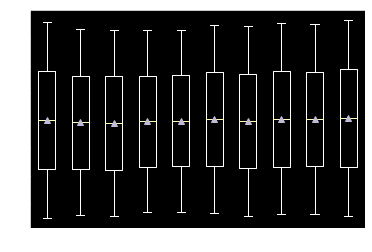

In [25]:
models = get_models()
run_evaluation(models)

#### Explore the learning rate

In [26]:
from numpy import arange
def generate_models():
    """Generates a dict of models with different learning rates"""
    return { '%.3f' % i : AdaBoostClassifier(learning_rate=i) for i in arange(0.1, 2.1, 0.1) }

>1 0.759 (0.046)
>2 0.732 (0.053)
>3 0.728 (0.050)
>4 0.724 (0.057)
>5 0.737 (0.067)
>6 0.735 (0.063)
>7 0.746 (0.062)
>8 0.755 (0.056)
>9 0.749 (0.059)
>10 0.742 (0.065)


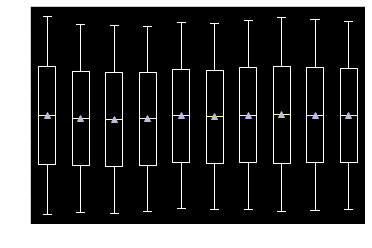

In [27]:
models = get_models()
run_evaluation(models)

#### Explore alternate algorithm

In [29]:
from sklearn.linear_model import LogisticRegression

classifier_lg = AdaBoostClassifier(base_estimator=LogisticRegression())
# results = run_classifier(classifier_lg,features_train, labels_train, features_test, labels_test)
# pd.DataFrame(results).plot(kind='bar')

### Pipeline: AdaBoost Parameter Evaluation


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def build_pipeline(params, classifier, clf='clf'):
    # Setting up a pipeline
    pipe = Pipeline([
        (clf, classifier)
    ])

    # Cross validation
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Set up the grid search
    gs = GridSearchCV(pipe,params,n_jobs=-1,cv=rskf,scoring='accuracy')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')
    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)

    return best_par

In [34]:
# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[10, 50, 100, 500],
    'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}



Best score: 0.7725448679169186
Best parameters: 
{'clf__learning_rate': 0.01, 'clf__n_estimators': 500}

Score: 0.734375
Accuracy: 0.734375
Precision: 0.73
Recall: 0.73
F1 score: 0.73
AUROC score: 0.68


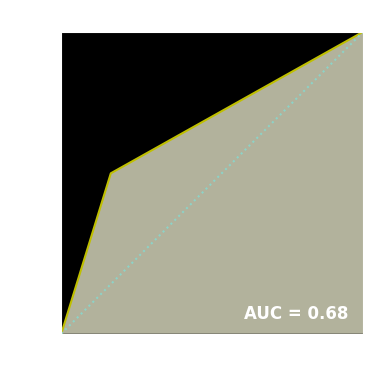

In [35]:
best_par_adaBoost = build_pipeline(params, AdaBoostClassifier())

{'accuracy': 0.734375,
 'precision': 0.7267418712674187,
 'recall': 0.734375,
 'fi': 0.7288409703504043,
 'auc': 0.68359375}